In [1]:
# https://musicinformationretrieval.com/ipython_audio.html
# https://musicinformationretrieval.com/ipython_audio.html

# https://github.com/drscotthawley/audio-classifier-keras-cnn/blob/master/augment_data.py
# https://github.com/PaddlePaddle/DeepSpeech/blob/develop/data_utils/augmentor/augmentation.py

# https://github.com/PaddlePaddle/DeepSpeech/blob/develop/data_utils/audio.py

In [2]:
# white noise generator
# https://github.com/see--/speech_recognition/blob/master/generate_noise.py

# add MFCC to spectogram
# https://github.com/see--/speech_recognition/blob/master/audio.py

# http://python-acoustics.github.io/python-acoustics/_modules/acoustics/generator.html

# background noise processing
# https://github.com/see--/speech_recognition/blob/master/input_data.py

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import os
import random
import numpy as np
import math
from datetime import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.transforms as transforms

from warpctc_pytorch import CTCLoss

from lib.vocabulary import Vocabulary
from lib.dataloader.audio import AudioDataset, BucketingSampler, collate_fn, DummyDataset, dummy_collate_fn
from lib.transforms.general import FromNumpyToTensor, TranscriptEncodeCTC
from lib.transforms.audio import AudioSpectrogram, AudioNoiseInjection, AudioNoiseGeneration, \
                                 AudioNormalizeDB, AudioNormalize, AudioPitchShift, AudioTimeStrech, \
                                 AudioDynamicRange, AudioTimeShift, AudioNoiseGeneration
from lib.models.deepspeech2 import DeepSpeech2
from lib.trainer import Trainer
from lib.evaluator import Evaluator
from lib.recognizer import Recognizer
from lib.scorer import Scorer
from lib.decoder import CTCGreedyDecoder, CTCBeamSearchDecoder
from lib.logger import *
from lib.stopping import *
from lib.checkpoint import *
from lib.utilities import *
from lib.tools import *


%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-11-24 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 1.0.0a0+1e45e7a
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit
GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 94%


In [11]:
from datetime import datetime

H = HYPERPARAMETERS({
    'EXPERIMENT'                    : 'AN4',
    'DESCRIPTION'                   : 'Deepspeech2 model ',
    'TIMESTAMP'                     : datetime.now().strftime('%Y_%m_%d_%H_%M_%S_%f') ,
    
    'MODEL_NAME'                    : 'AN4_CTC_deepspeech2_no_augmentation',
    
    'PRELOAD_MODEL_PATH'            : None, #'AN4_CTC_deepspeech2_with_augmentation_preload.tar',
    
    'ROOT_DIR'                      : 'data',
    'MANIFESTS'                     : ['manifest.json'], #, 'manifest_pseudo.json'],

    'BATCH_SIZE'                    : 20,
    'NUM_WORKERS'                   : 8,
        
    'RNN_HIDDEN_SIZE'               : 800,
    'NUM_LAYERS'                    : 5,
    'RNN_DROPOUT'                   : 0.5,
    'CNN_DROPOUT'                   : 0.5,
    'BIDIRECTIONAL'                 : True ,

    'LR'                            : 0.0003,
    'LR_LAMBDA'                     : lambda epoch: max(math.pow(0.78, math.floor((1 + epoch) / 200.0)), 0.01), 
    'WEIGHT_DECAY'                  : 0, 
    'MOMENTUM'                      : 0.9 ,
    'NESTEROV'                      : True ,
    
    'MAX_GRAD_NORM'                 : 400,
    
    'NUM_EPOCHS'                    : 70,
    
    'STOPPING_PATIENCE'             : 40,
    
    'CHECKPOINT_INTERVAL'           : 140 ,
    'CHECKPOINT_RESTORE'            : False ,
    
    'USE_CUDA'                      : torch.cuda.is_available(),
        
    'SEED'                          : 123456,

    'DATASET_MEAN_STD'              : (0.060487103, 0.16884679),

    'NORMALIZE_DB'                  : -40,
    'NORMALIZE_MAX_GAIN'            : 300,

    'MIN_MAX_AUDIO_DURATION'        : None, # (1, 15),
    'MIN_MAX_TRANSCRIPT_LEN'        : None, # (3, 60),
    'MIN_TRANSCRIPT_CONFIDENCE'     : None, # 0.85,
    
    'AUDIO_SAMPLE_RATE'             : 16000,

    'SPECT_WINDOW_SIZE'             : 0.02,
    'SPECT_WINDOW_STRIDE'           : 0.01,
    'SPECT_WINDOW'                  : 'hamming',

    'NOISE_BG_PROBABILITY'          : 0.4,
    'NOISE_BG_LEVELS'               : (0.0, 0.5),
    'NOISE_BG_DIR'                  : './data/BACKGROUND_NOISE',
  
    'AUDIO_PITCH_PROBABILITY'       : 0.4,
    'AUDIO_PITCH_PM'                : 4,     
    
    'AUDIO_SPEED_PROBABILITY'       : 0.4,
    'AUDIO_SPEED_LOW_HIGH'          : (0.9, 1.1),    
    
    'AUDIO_DYNAMIC_PROBABILITY'     : 0.4,
    'AUDIO_DYNAMIC_LOW_HIGH'        : (0.5, 1.1),    
    
    'AUDIO_SHIFT_PROBABILITY'       : 0.4,
    'AUDIO_SHIFT_PERCENT'           : 0.2,    
    
    'AUDIO_NOISE_PROBABILITY'       : 0.4,
    'AUDIO_NOISE_LEVELS'            : (0.0, 0.5),
    'AUDIO_NOISE_COLORS'            : ['white', 'pink', 'blue', 'brown', 'violet'],
})

In [12]:
random.seed(H.SEED)
np.random.seed(H.SEED)
torch.manual_seed(H.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(H.SEED)
    torch.cuda.manual_seed_all(H.SEED)

In [13]:
import librosa.display

def plot_wave(data, sr):
    plt.figure(figsize=(14, 5))
    plt.title('Time Domain (raw)')
    plt.ylabel('Amplitude')

    librosa.display.waveplot(data, sr=sr);

In [14]:
def plot_specgram(data, sr):
    plt.figure(figsize=(14, 5))
    plt.title('Spectogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.specgram(data, Fs=sr);

In [15]:
import scipy

EPS = 1e-8

WINDOWS = {'hamming': scipy.signal.hamming, 'hann': scipy.signal.hann, 'blackman': scipy.signal.blackman,
                   'bartlett': scipy.signal.bartlett}

def get_spectrogram(wav):
    window_stride = H.SPECT_WINDOW_STRIDE
    window_size = H.SPECT_WINDOW_SIZE
    sample_rate = H.AUDIO_SAMPLE_RATE
    window = WINDOWS.get(H.SPECT_WINDOW, WINDOWS['hamming'])        

    n_fft = int(sample_rate * window_size)
    win_length = n_fft
    hop_length = int(sample_rate * window_stride)

    D = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, _ = librosa.magphase(D)
    return spect

def plot_specgram(data, sr):
    log_spect = np.log(get_spectrogram(data))

    plt.figure(figsize=(8, 5))
    plt.imshow(log_spect, aspect='auto', origin='lower',)
    plt.colorbar()
    plt.title('Spectrogram {}'.format(log_spect.shape))

In [16]:
vocab = Vocabulary(os.path.join(H.ROOT_DIR, H.EXPERIMENT), encoding="ctc")

vocab, len(vocab)

(_'ABCDEFGHIJKLMNOPQRSTUVWXYZ , 29)

In [17]:
dataset = AudioDataset(os.path.join(H.ROOT_DIR, H.EXPERIMENT), manifests_files=H.MANIFESTS, datasets="train")
sr = H.AUDIO_SAMPLE_RATE
audio_path = dataset.manifest[0]['recording_path']
transcript_path = dataset.manifest[0]['transcript_path']
duration = dataset.manifest[0]['recording_duration']

audio_path, transcript_path, duration

('./data/AN4/train/wav/an251-fash-b.wav',
 './data/AN4/train/txt/an251-fash-b.txt',
 1.0)

YES
<class 'numpy.ndarray'> (16000,) 16000 16000


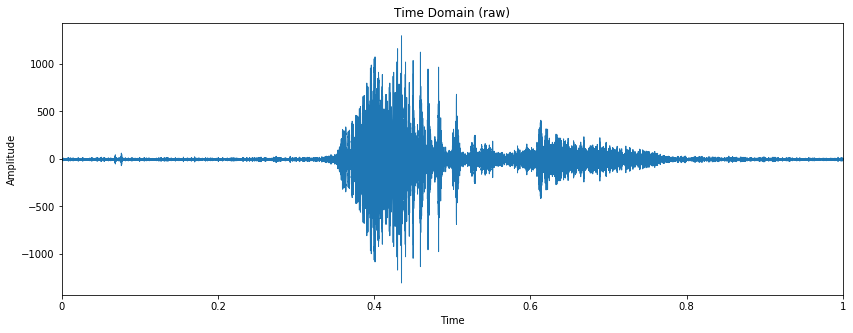

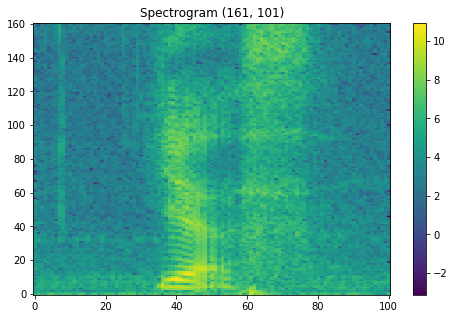

In [18]:
from scipy.io import wavfile
import IPython.display as ipd
from matplotlib.pyplot import specgram

with open(transcript_path, "r") as file:
    print( file.read() )
    
sr, data = wavfile.read(audio_path)
data = data.astype(float)

plot_wave(data, sr)

plot_specgram(data, sr)

print(type(data), data.shape, len(data), sr)

ipd.Audio(data, rate=sr)

In [19]:
class AudioTimeShift(object):
    def __init__(self, probability=0.4, sample_rate=16000, min_max=0.2):
        self.probability = probability
        self.sample_rate = sample_rate
        self.min_max = min_max

    def __call__(self, data):
        if random.random() < self.probability:
            shift_ms = random.uniform(self.min_max[0], self.min_max[1])
            data = self.shift_in_time(data, self.sample_rate, shift_ms )
        return data

    @staticmethod
    def shift_in_time(data, sample_rate, shift_ms):
        """
        https://github.com/PaddlePaddle/DeepSpeech/blob/develop/data_utils/audio.py
        Shift the audio in time. If `shift_ms` is positive, shift with time
        advance; if negative, shift with time delay. Silence are padded to
        keep the duration unchanged.
        """
        shift_samples = int(shift_ms * sample_rate / 1000)
        if shift_samples > 0:
            # time advance
            data[:-shift_samples] = data[shift_samples:]
            data[-shift_samples:] = 0
        elif shift_samples < 0:
            # time delay
            data[-shift_samples:] = data[:shift_samples]
            data[:-shift_samples] = 0
        return data

    def __repr__(self):
        return self.__class__.__name__ + '(probability={0}, sample_rate={1}, min_max={2})'.format(
                                            self.probability, self.sample_rate, self.min_max)


In [32]:
shift = AudioTimeShift(probability=1.0, sample_rate=16000, min_max=(-100,+100))

In [39]:
infile = './data/AN4/train/wav/an89-fbbh-b.wav' #'./data/AN4/train/wav/an251-fash-b.wav'
sr, data = wavfile.read(infile)
data = data.astype(float)
d = shift(data.copy())

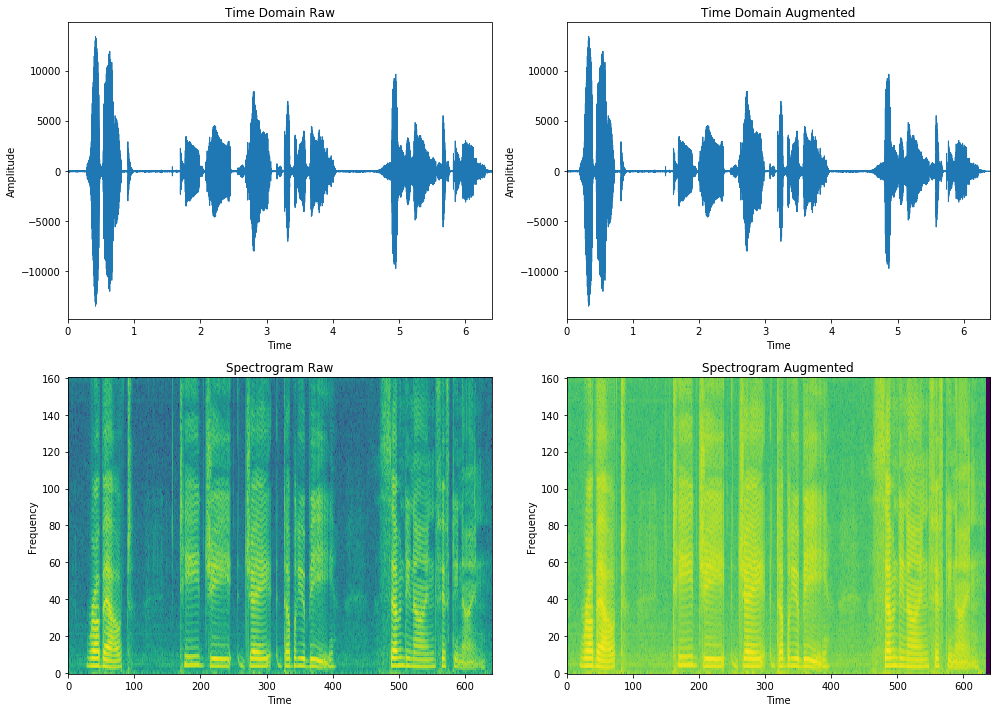

In [40]:
fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [12]:
# change speed and pitch together
def change_speed_pitch(data, low=0.9, high=1.1):
    length = len(data)
    length_change = np.random.uniform(low=low, high=high)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,length, speed_fac), np.arange(0, length), data)
    
    minlen = min( data.shape[0], tmp.shape[0])         
    return np.r_[data[0:minlen], np.random.uniform(-0.001,0.001, length - minlen)]

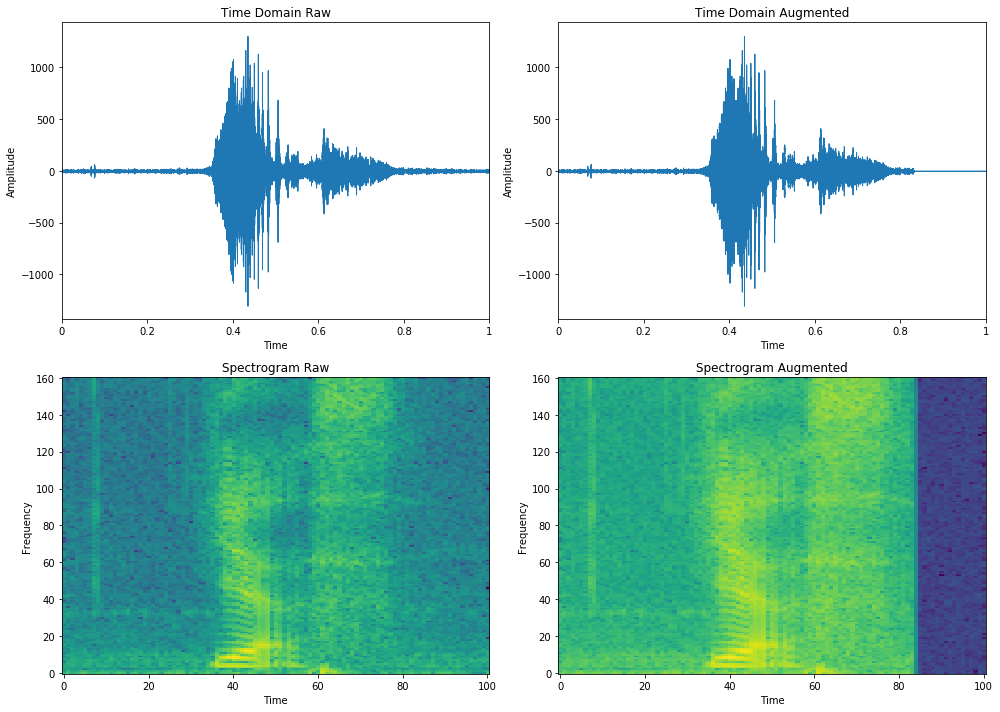

In [43]:
sr, data = wavfile.read(audio_path)
data = data.astype(float)

d = change_speed_pitch(data.copy(), low=0.8, high=1.2)

fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [14]:
HH = HYPERPARAMETERS({
    
    'AUDIO_SAMPLE_RATE'             : 16000,

    'AUDIO_PITCH_PROBABILITY'       : 1.0,
    'AUDIO_PITCH_PM'                : 4,     
})

In [15]:
pitch = AudioPitchShift(probability=HH.AUDIO_PITCH_PROBABILITY,
                        sample_rate=HH.AUDIO_SAMPLE_RATE, 
                        pitch_pm=HH.AUDIO_PITCH_PM)

pitch

AudioPitchShift(probability=1.0, sample_rate=16000, pitch_pm=4)

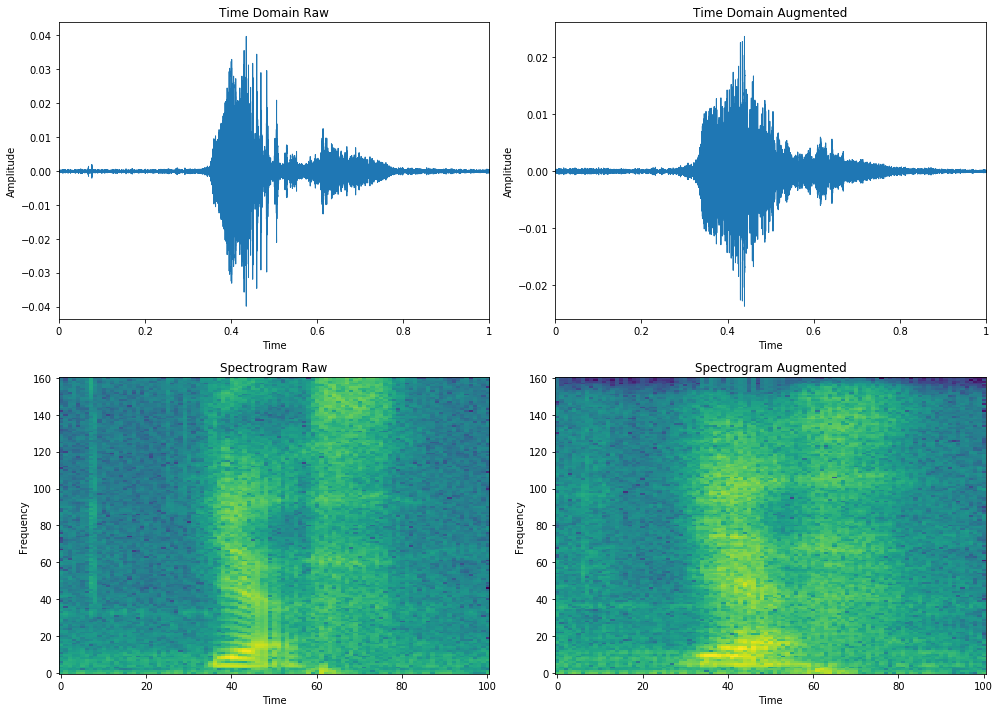

In [16]:
audio_path = dataset.manifest[0]['recording_path']
data = AudioDataset.load_audio(audio_path, HH.AUDIO_SAMPLE_RATE)

d = pitch(data.copy())

fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [17]:
HH = HYPERPARAMETERS({
    
    'AUDIO_SAMPLE_RATE'             : 16000,

    'AUDIO_SPEED_PROBABILITY'       : 1.0,
    'AUDIO_SPEED_LOW_HIGH'          : (0.9, 1.1),    
})

In [18]:
time = AudioTimeStrech(probability=HH.AUDIO_SPEED_PROBABILITY,
                       low_high=HH.AUDIO_SPEED_LOW_HIGH)

time

AudioTimeStrech(probability=1.0, low_high=(0.9, 1.1))

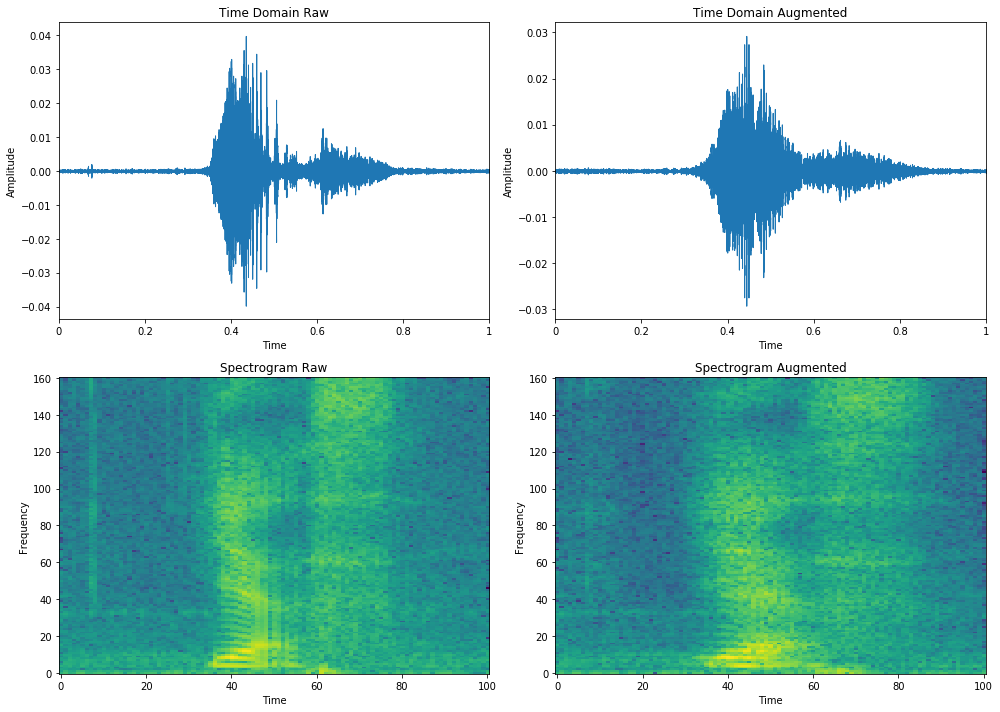

In [19]:
audio_path = dataset.manifest[0]['recording_path']
data = AudioDataset.load_audio(audio_path, HH.AUDIO_SAMPLE_RATE)

d = time(data.copy())

fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [20]:
HH = HYPERPARAMETERS({
    
    'AUDIO_SAMPLE_RATE'             : 16000,

    'AUDIO_DYNAMIC_PROBABILITY'     : 1.0,
    'AUDIO_DYNAMIC_LOW_HIGH'        : (0.5, 1.1),    
})

In [21]:
drange = AudioDynamicRange(probability=HH.AUDIO_DYNAMIC_PROBABILITY,
                          low_high=HH.AUDIO_DYNAMIC_LOW_HIGH)

drange

AudioDynamicRange(probability=1.0, low_high=(0.5, 1.1))

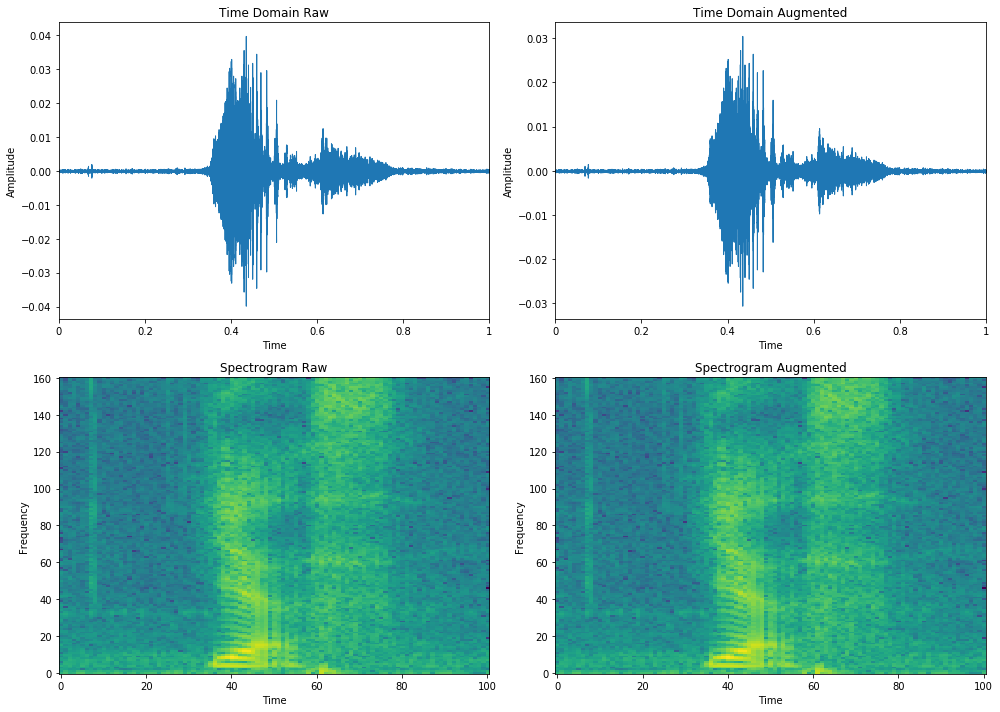

In [22]:
audio_path = dataset.manifest[0]['recording_path']
data = AudioDataset.load_audio(audio_path, HH.AUDIO_SAMPLE_RATE)

d = drange(data.copy())

fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [23]:
HH = HYPERPARAMETERS({
    
    'AUDIO_SAMPLE_RATE'             : 16000,

    'AUDIO_NOISE_PROBABILITY'       : 0.4,
    'AUDIO_NOISE_LEVELS'            : (0.0, 0.5),
    'AUDIO_NOISE_COLORS'            : ['white', 'pink', 'blue', 'brown', 'violet'],
})

In [24]:
gnoise = AudioNoiseGeneration(probability=HH.AUDIO_NOISE_PROBABILITY,
                               noise_levels=HH.AUDIO_NOISE_LEVELS,
                               noise_colors=HH.AUDIO_NOISE_COLORS)

gnoise

AudioNoiseGeneration(probability=0.4, noise_levels=(0.0, 0.5), noise_colors['white', 'pink', 'blue', 'brown', 'violet'])

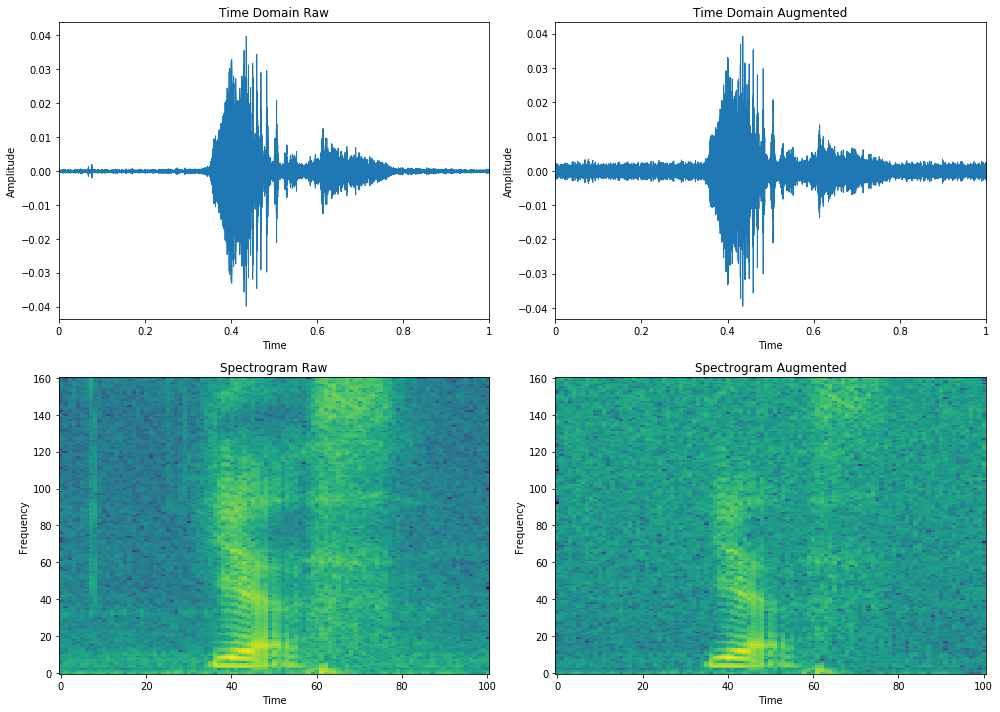

In [25]:
audio_path = dataset.manifest[0]['recording_path']
data = AudioDataset.load_audio(audio_path, HH.AUDIO_SAMPLE_RATE)

d = gnoise(data.copy())

fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [26]:
HH = HYPERPARAMETERS({
    
    'AUDIO_SAMPLE_RATE'             : 16000,

    'AUDIO_SHIFT_PROBABILITY'       : 1.0,
    'AUDIO_SHIFT_PERCENT'           : 0.2,    
})

In [27]:
shift = AudioShiftTime(probability=HH.AUDIO_SHIFT_PROBABILITY,
                       percent=HH.AUDIO_SHIFT_PERCENT)

shift

AudioShiftTime(probability=1.0, percent=0.2)

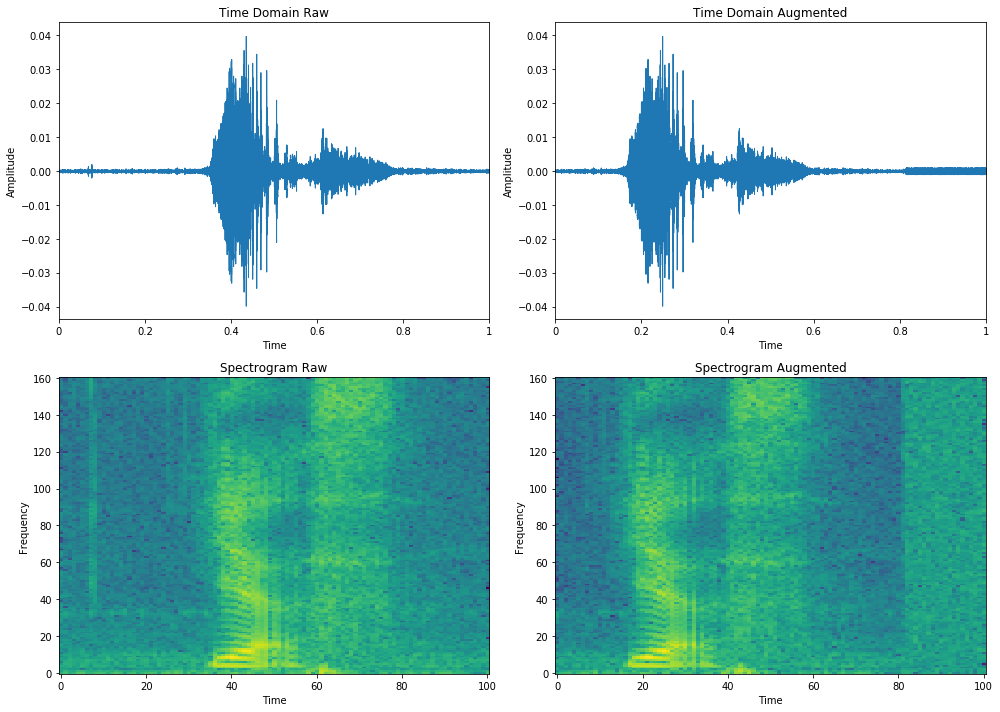

In [28]:
audio_path = dataset.manifest[0]['recording_path']
data = AudioDataset.load_audio(audio_path, HH.AUDIO_SAMPLE_RATE)

d = shift(data.copy())

fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [29]:
from datetime import datetime

HH = HYPERPARAMETERS({
    'AUDIO_SAMPLE_RATE'             : 16000,

    'SPECT_WINDOW_SIZE'             : 0.02,
    'SPECT_WINDOW_STRIDE'           : 0.01,
    'SPECT_WINDOW'                  : 'hamming',

    'NOISE_BG_PROBABILITY'          : 0.4,
    'NOISE_BG_LEVELS'               : (0.0, 0.5),
    'NOISE_BG_DIR'                  : './data/BACKGROUND_NOISE',
  
    'AUDIO_PITCH_PROBABILITY'       : 0.4,
    'AUDIO_PITCH_PM'                : 4,     
    
    'AUDIO_SPEED_PROBABILITY'       : 0.4,
    'AUDIO_SPEED_LOW_HIGH'          : (0.9, 1.1),    
    
    'AUDIO_DYNAMIC_PROBABILITY'     : 0.4,
    'AUDIO_DYNAMIC_LOW_HIGH'        : (0.5, 1.1),    
    
    'AUDIO_SHIFT_PROBABILITY'       : 0.4,
    'AUDIO_SHIFT_PERCENT'           : 0.2,    
    
    'AUDIO_NOISE_PROBABILITY'       : 0.4,
    'AUDIO_NOISE_LEVELS'            : (0.0, 0.5),
    'AUDIO_NOISE_COLORS'            : ['white', 'pink', 'blue', 'brown', 'violet'],
})

In [30]:
data = AudioDataset.load_audio(audio_path, H.AUDIO_SAMPLE_RATE)

audio_transform_train = transforms.Compose([
                AudioNoiseInjection( probability=HH.NOISE_BG_PROBABILITY, 
                                     noise_levels=HH.NOISE_BG_LEVELS, 
                                     noise_dir=HH.NOISE_BG_DIR),
                AudioPitchShift( probability=HH.AUDIO_PITCH_PROBABILITY,
                                 sample_rate=HH.AUDIO_SAMPLE_RATE,
                                 pitch_pm=HH.AUDIO_PITCH_PM),
                AudioTimeStrech( probability=HH.AUDIO_SPEED_PROBABILITY,
                                 low_high=HH.AUDIO_SPEED_LOW_HIGH),
                AudioDynamicRange( probability=HH.AUDIO_DYNAMIC_PROBABILITY,
                                   low_high=HH.AUDIO_DYNAMIC_LOW_HIGH),
                AudioShiftTime( probability=HH.AUDIO_SHIFT_PROBABILITY,
                                percent=HH.AUDIO_SHIFT_PERCENT),
                AudioNoiseGeneration( probability=HH.AUDIO_NOISE_PROBABILITY,
                                      noise_levels=HH.AUDIO_NOISE_LEVELS,
                                      noise_colors=HH.AUDIO_NOISE_COLORS)
])

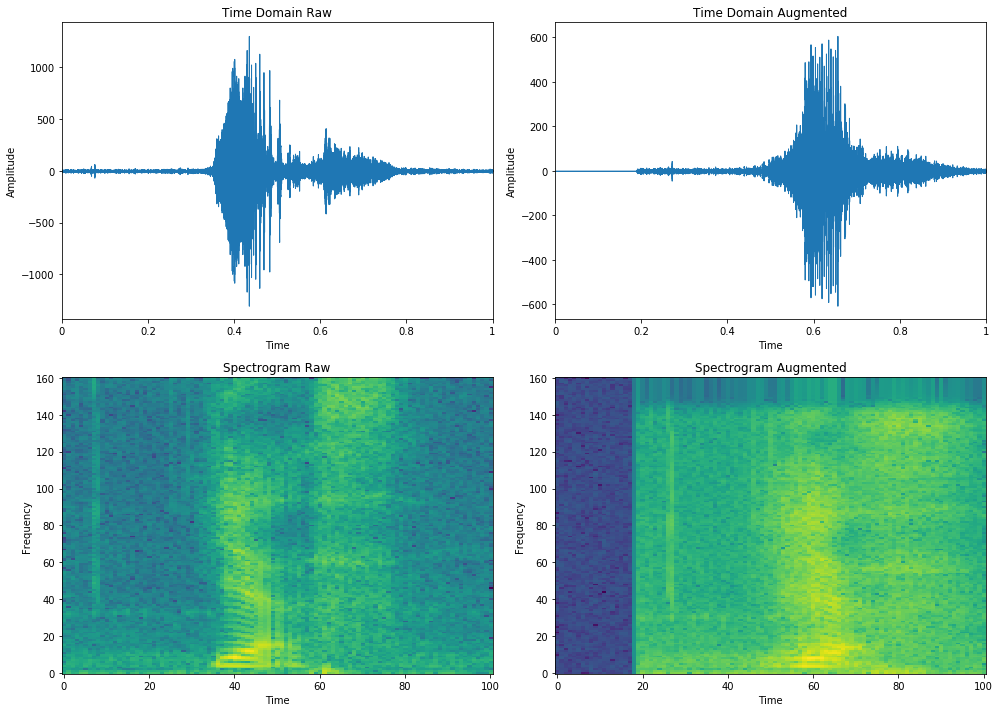

In [31]:
sr, data = wavfile.read(audio_path)
data = data.astype(float)

d = audio_transform_train(data)

fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(d, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(d.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=d, rate=sr))

plt.tight_layout()

In [32]:
data = AudioDataset.load_audio(audio_path, H.AUDIO_SAMPLE_RATE)
sr = H.AUDIO_SAMPLE_RATE

display(ipd.Audio(data=data, rate=sr))

In [33]:
AudioNoiseInjection.create_manifest('./data/BACKGROUND_NOISE', H.AUDIO_SAMPLE_RATE, verbose=1)

Creating background noise manifest:  ./data/BACKGROUND_NOISE
Total entries:  5
Manifest file in:  ./data/BACKGROUND_NOISE/manifest.json
...done. 


In [34]:
data = AudioDataset.load_audio(audio_path, H.AUDIO_SAMPLE_RATE)

noise = AudioNoiseInjection(probability=H.NOISE_BG_PROBABILITY, 
                            noise_levels=H.NOISE_BG_LEVELS, 
                            noise_dir=H.NOISE_BG_DIR)

noise

AudioNoiseInjection(probability=0.4, noise_levels=(0.0, 0.5), noise_dir./data/BACKGROUND_NOISE)

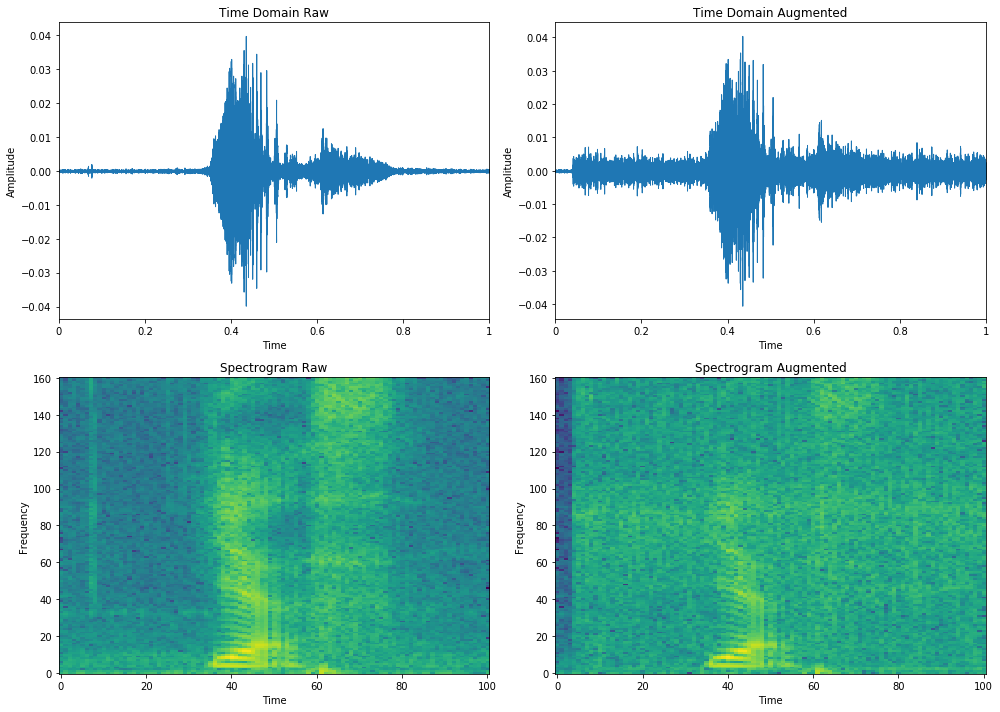

In [35]:
t = noise(data.copy())


fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Raw')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].set_title('Time Domain Augmented')
ax[0][1].set_ylabel('Amplitude')
librosa.display.waveplot(t, sr=sr, ax=ax[0][1])

ax[1][0].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[1][0].set_title('Spectrogram Raw')
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Frequency')

ax[1][1].imshow(np.log(get_spectrogram(t.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Augmented')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')

display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=t, rate=sr))

plt.tight_layout()

In [36]:
AudioNormalizeDB.compute_rms_db(dataset, datasets=['train'], samples=None)

(-47.66678810119629, -22.44837999343872, -30.84806500607905)

In [37]:
normDB = AudioNormalizeDB(db=H.NORMALIZE_DB, max_gain_db=H.NORMALIZE_MAX_GAIN)

normDB

AudioNormalizeDB(db=-40, max_gain_db=300)

In [38]:
data = AudioDataset.load_audio(audio_path, H.AUDIO_SAMPLE_RATE)

AudioNormalizeDB.get_rms_db(data)

-47.66678810119629

In [39]:
t = normDB(data.copy())

AudioNormalizeDB.get_rms_db(t)

-40.0

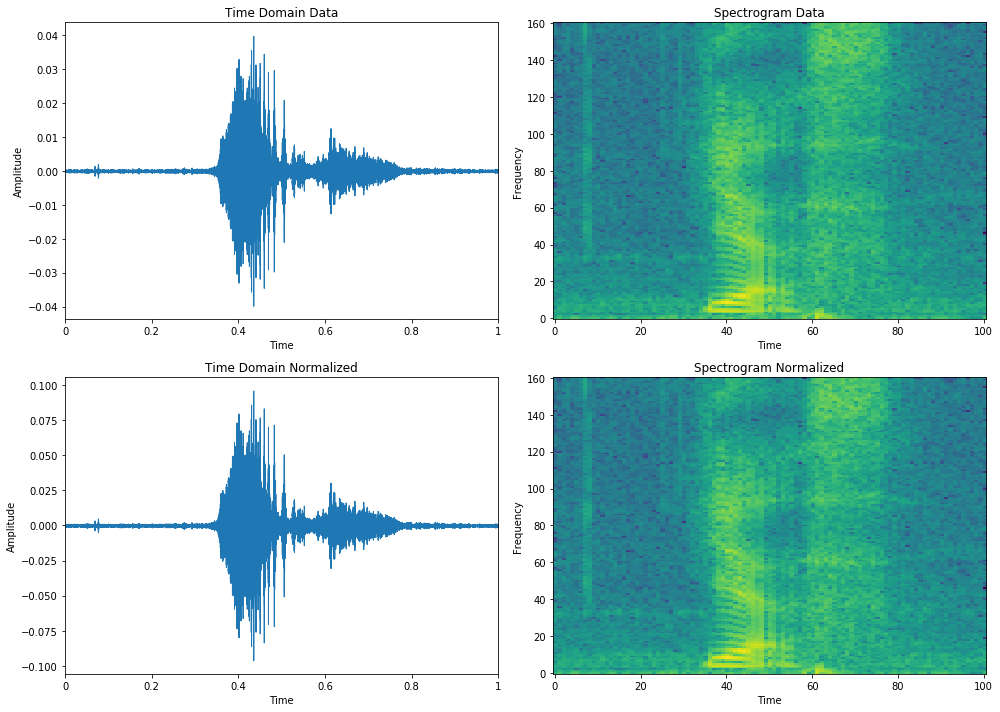

In [40]:
fig, ax = plt.subplots(2, 2, sharey=False, figsize=(14, 10))

ax[0][0].set_title('Time Domain Data')
ax[0][0].set_ylabel('Amplitude')
librosa.display.waveplot(data, sr=sr, ax=ax[0][0])

ax[0][1].imshow(np.log(get_spectrogram(data.astype(float))+EPS), aspect='auto', origin='lower',)
ax[0][1].set_title('Spectrogram Data')
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Frequency')

ax[1][0].set_title('Time Domain Normalized')
ax[1][0].set_ylabel('Amplitude')
librosa.display.waveplot(t, sr=sr, ax=ax[1][0])

ax[1][1].imshow(np.log(get_spectrogram(t.astype(float))+EPS), aspect='auto', origin='lower')
ax[1][1].set_title('Spectrogram Normalized')
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('Frequency')


display(ipd.Audio(data=data, rate=sr))
display(ipd.Audio(data=t, rate=sr))

plt.tight_layout()